In [ ]:
# Our aim in this study is to determine which factors influence whether a loan is considered good or bad. By analyzing customer attributes, we will predict whether each applicant’s loan should be approved.
# Accordingly, the dependent variable ( y ) is the loan-approval outcome—“Yes” or “No,” indicating a good or bad loan, respectively.

In [ ]:
# Reference : https://github.com/Pitsillides91/Python-Tutorials/blob/master/Introduction%20to%20ML%20-%20Logistic%20Regression%20Example/

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from math import sqrt

%matplotlib inline

In [2]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
sns.set(rc={'figure.figsize':(12,10)})

In [4]:
raw_data = pd.read_csv('/content/Logistic Regression Dummy Data v3.csv')
print(raw_data.shape)
raw_data.head(5)

(1006, 14)


,Type of Account,Account History,Reason for the Loan,Loan Amount,Account Savings,Employment History,Individual Stauts,Other Loans,Security / Collateral,Age,Residence Status,Job,Completed Other loan?,Good Loan
0,No Data,critical,Learning / Edu purposes,2116.0,0-200,5-7 Years,Male,No,Property - Real Estate,47.0,House Owner,Services,No,No
1,No Data,critical,TV,2438.0,No Data,7+ Years,Male,No,Savings Account,52.0,House Owner,Skilled Labor,No,No
2,No Data,critical,Buying a New Car,2144.0,0-200,2-5 Years,Male,No,Vehicle,48.0,House Owner,Skilled Labor,No,No
3,No Data,critical,Home furniture,2073.0,No Data,2-5 Years,Married,No,Vehicle,25.0,House Owner,Skilled Labor,Yes,No
4,No Data,critical,Support for Business,1276.0,No Data,7+ Years,Male,No,No Security,59.0,Renting,Services,No,No


Data Preprocessing

In [6]:
raw_data.isnull().sum()
# When raw_data is a pandas DataFrame, it checks every cell for missing values (such as NaN, None, or NaT) and returns another DataFrame of the same shape containing True/False indicators.

,0
Type of Account,2
Account History,2
Reason for the Loan,3
Loan Amount,3
Account Savings,4
Employment History,5
Individual Stauts,5
Other Loans,5
Security / Collateral,5
Age,4


In [7]:
raw_data[raw_data['Employment History'].isnull()]

,Type of Account,Account History,Reason for the Loan,Loan Amount,Account Savings,Employment History,Individual Stauts,Other Loans,Security / Collateral,Age,Residence Status,Job,Completed Other loan?,Good Loan
686,Type C,Good,Buying a New Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
721,Type C,critical,Home furniture,5387.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
737,Type C,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,House Owner,Services,No,NaN
1005,NaN,NaN,NaN,1765.0,0-201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
raw_data = raw_data.dropna(subset = ['Employment History'])
print(raw_data.shape)
raw_data.isnull().sum()

(1001, 14)


,0
Type of Account,0
Account History,0
Reason for the Loan,0
Loan Amount,0
Account Savings,0
Employment History,0
Individual Stauts,0
Other Loans,0
Security / Collateral,0
Age,0


In [13]:
import pandas as pd

def summarize_columns(df: pd.DataFrame, cat_threshold: int = 10, top_n: int = 5) -> pd.DataFrame:
    """
    Summarize basic stats for each column of a DataFrame.
    """
    summary_rows = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=True)
        n_missing = series.isna().sum()
        dtype = series.dtype

        row = {
            "dtype": dtype,
            "n_unique": nunique,
            "missing": n_missing,
        }

        if nunique <= cat_threshold:
            # 고유값이 적은 '범주형 유사' 컬럼
            uniques = series.dropna().unique()      # ndarray
            uniques_sorted = sorted(uniques)        # list
            row["sample_or_top"] = uniques_sorted[:top_n]   # ★ .tolist() 제거!
        else:
            # 고유값이 많은 컬럼
            if pd.api.types.is_numeric_dtype(series):
                row["sample_or_top"] = f"min={series.min()}, max={series.max()}"
            else:
                top_vals = series.value_counts(dropna=True).nlargest(top_n).index.tolist()
                row["sample_or_top"] = top_vals

        summary_rows.append(row)

    summary = pd.DataFrame(summary_rows, index=df.columns)
    summary.index.name = "feature"
    return summary


In [14]:
summary_df = summarize_columns(raw_data, cat_threshold=10, top_n=3)
display(summary_df)

,dtype,n_unique,missing,sample_or_top
feature,,,,
Type of Account,object,4,0,"[No Data, Type A, Type B]"
Account History,object,3,0,"[Average (known delays), Good, critical]"
Reason for the Loan,object,10,0,"[Advance Edu/training, All other, Buying a New..."
Loan Amount,float64,911,0,"min=-548541254.0, max=18427.0"
Account Savings,object,5,0,"[0-200, 1000+, 200-500]"
Employment History,object,5,0,"[0-2 Years, 2-5 Years, 5-7 Years]"
Individual Stauts,object,5,0,"[Divorced, Female, Female_]"
Other Loans,object,2,0,"[No, Yes]"
Security / Collateral,object,4,0,"[No Security, Property - Real Estate, Savings ..."


Data Cleaning

In [16]:
raw_data = raw_data[raw_data['Age'] < 100]

raw_data.shape

(1000, 14)

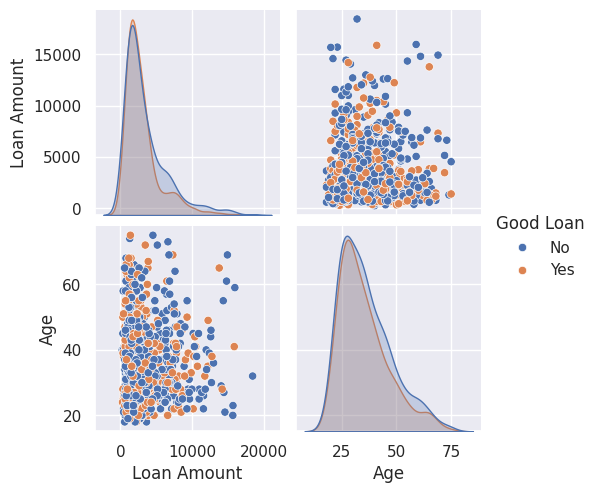

In [17]:
g = sns.pairplot(raw_data, hue = 'Good Loan')

<Axes: xlabel='Good Loan', ylabel='count'>

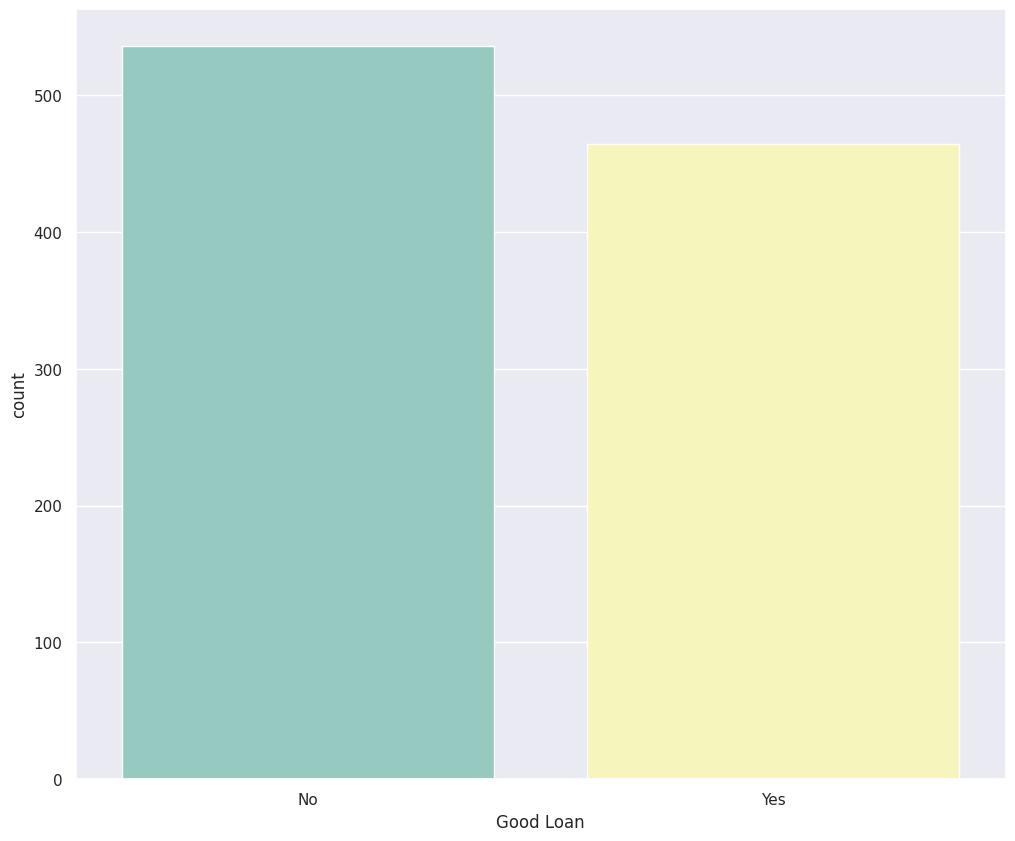

In [18]:
sns.countplot(x = 'Good Loan', data = raw_data, palette = 'Set3')

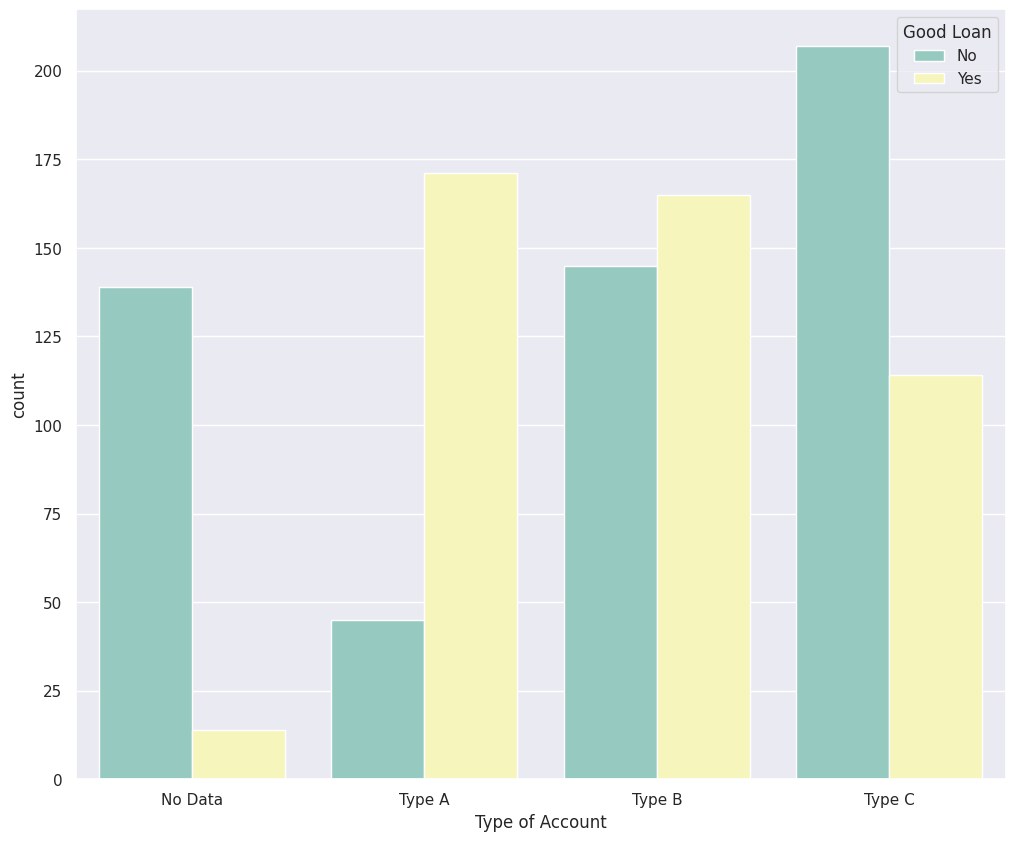

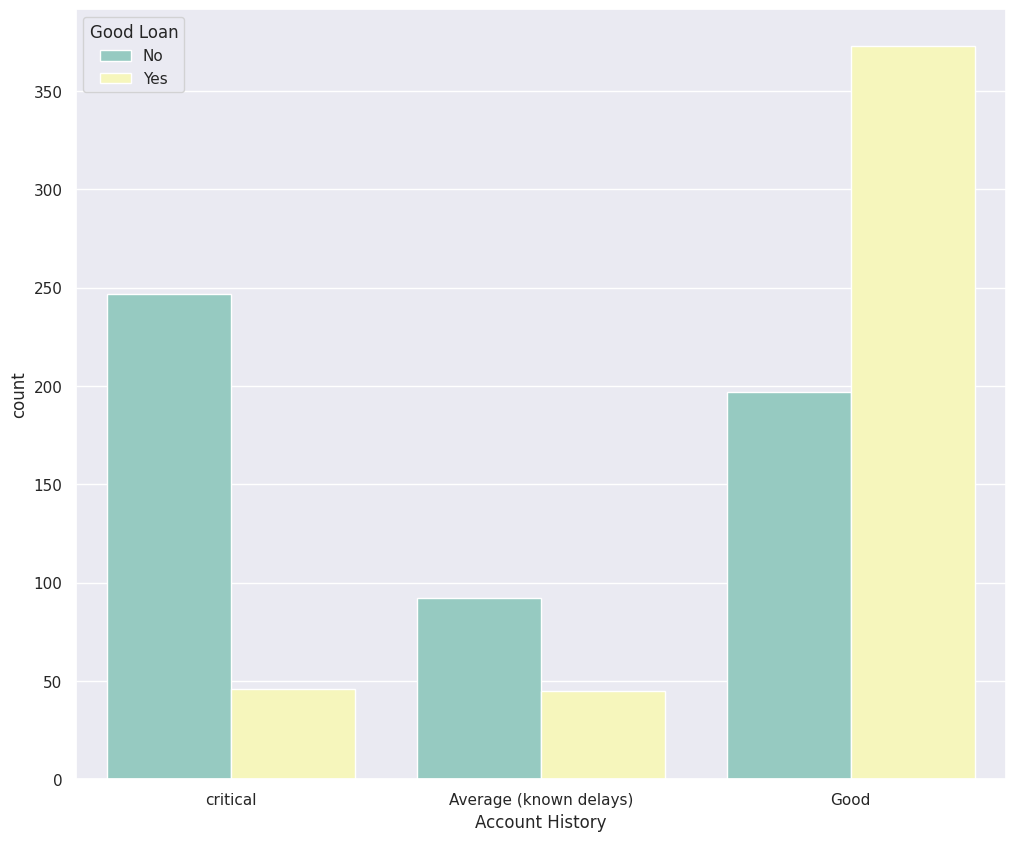

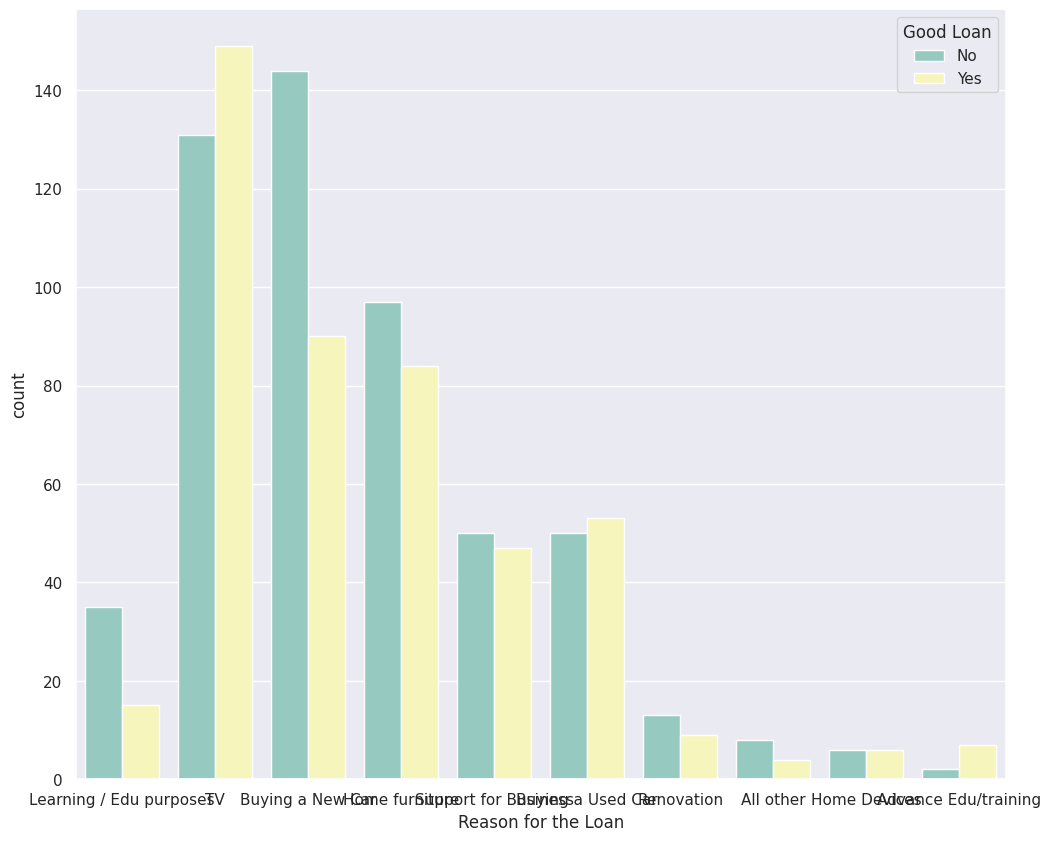

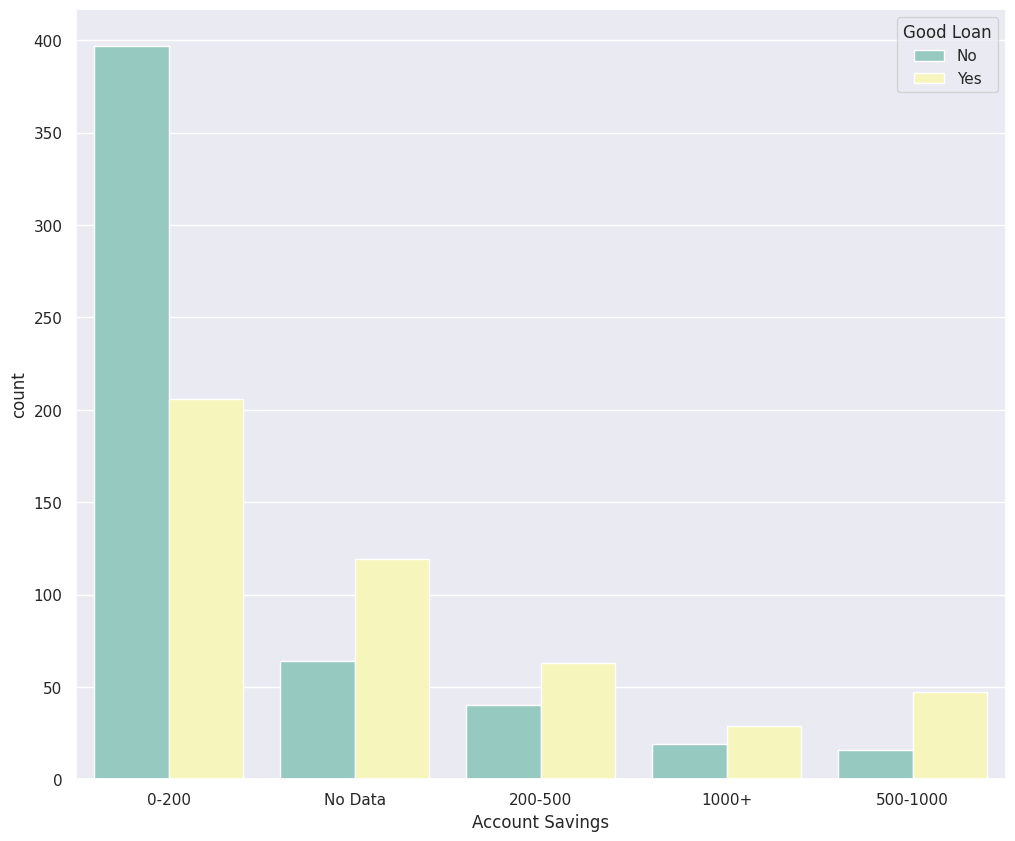

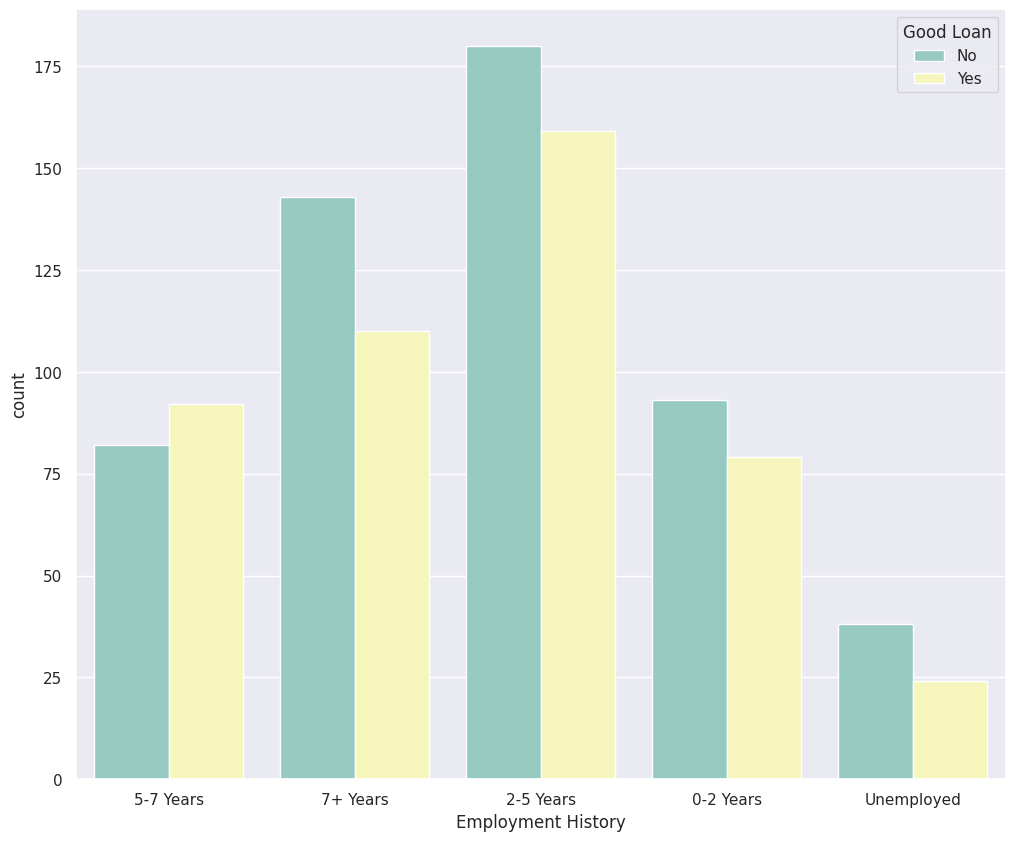

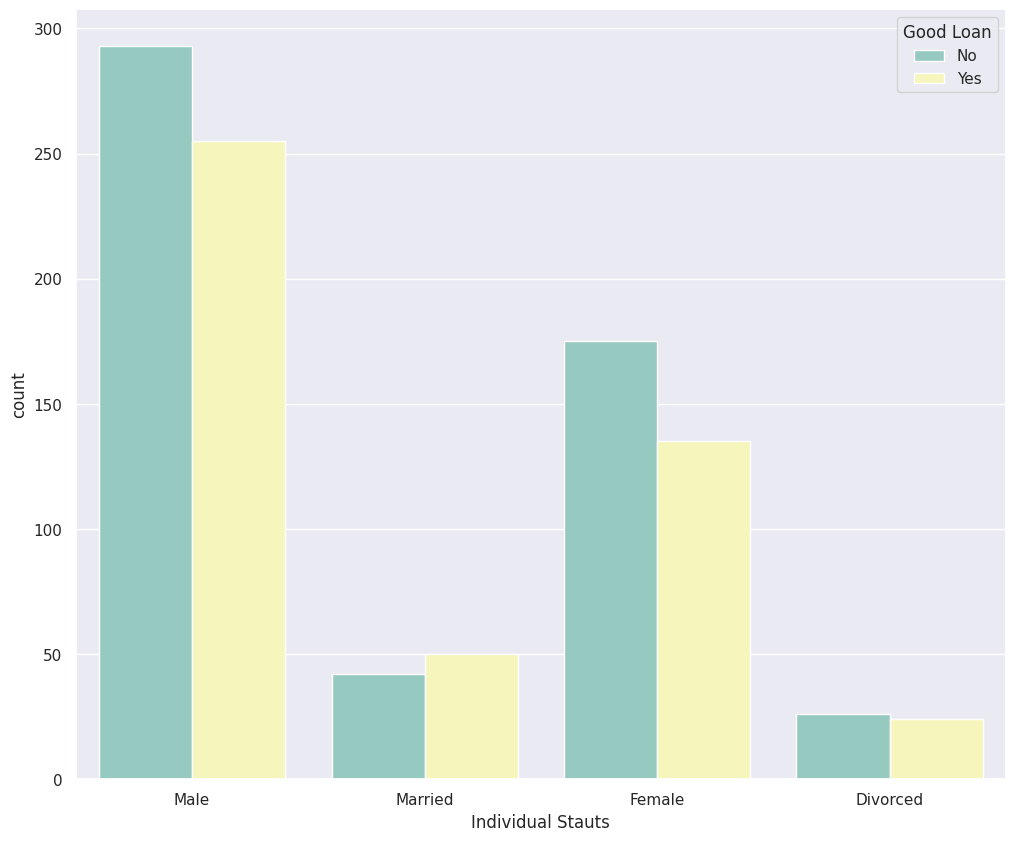

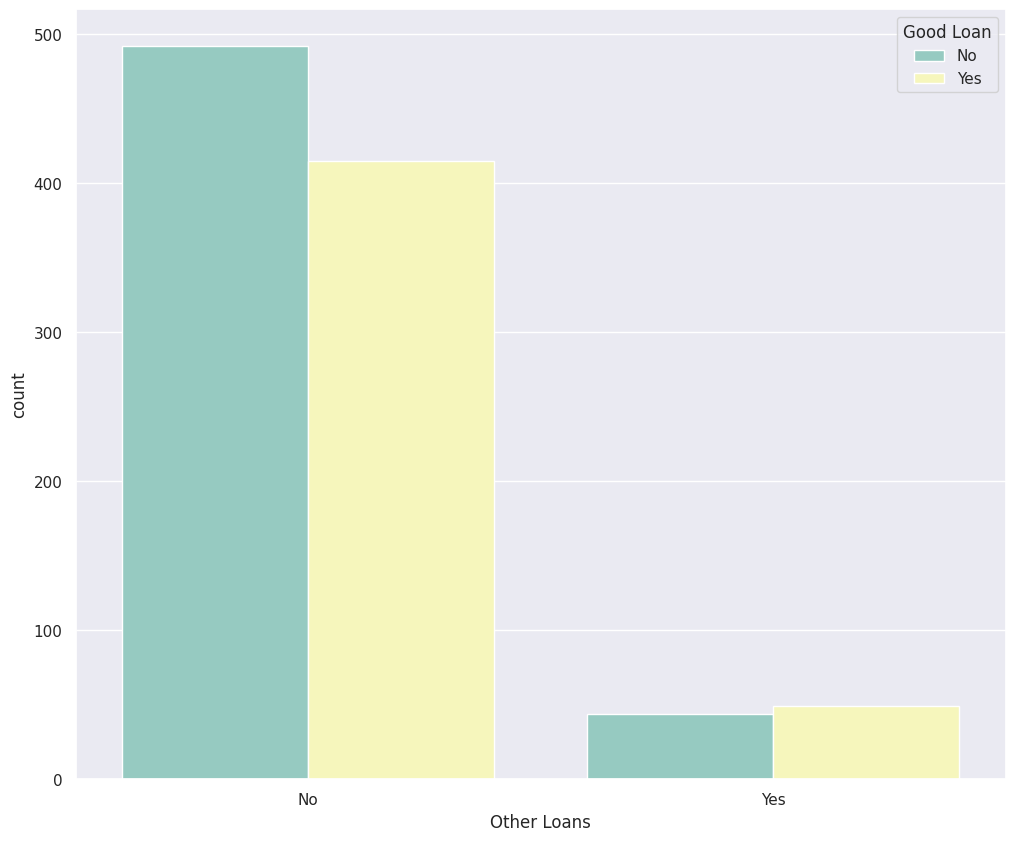

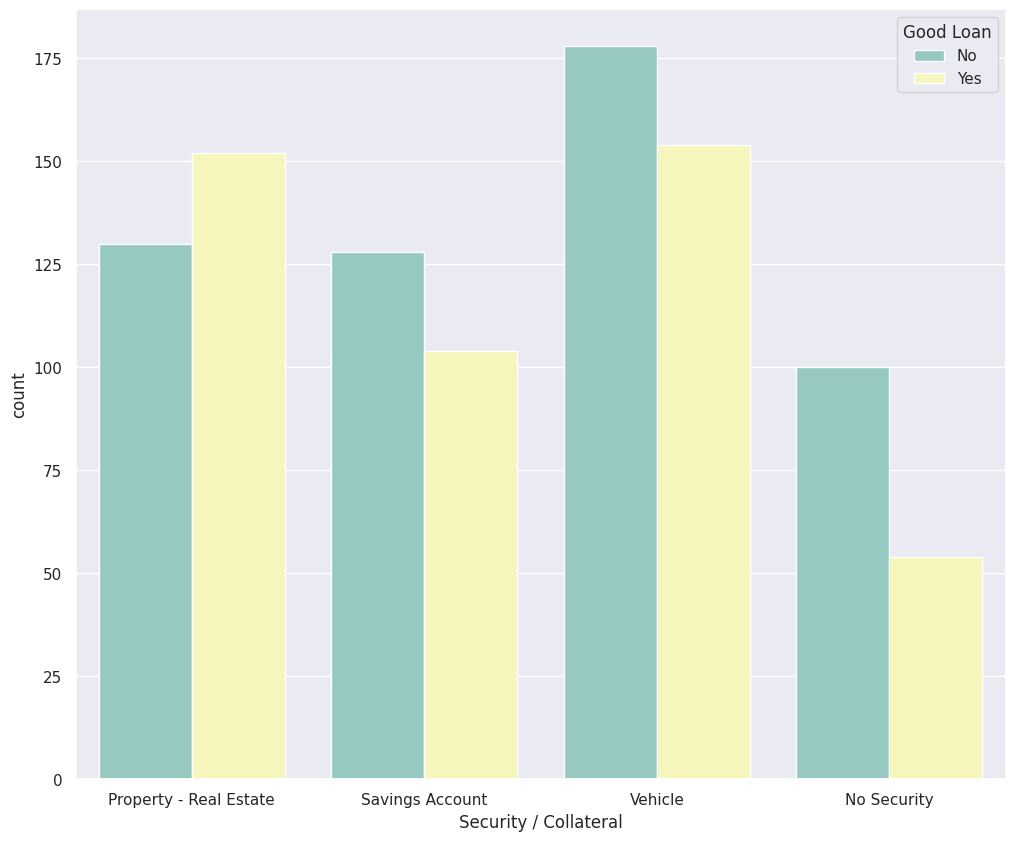

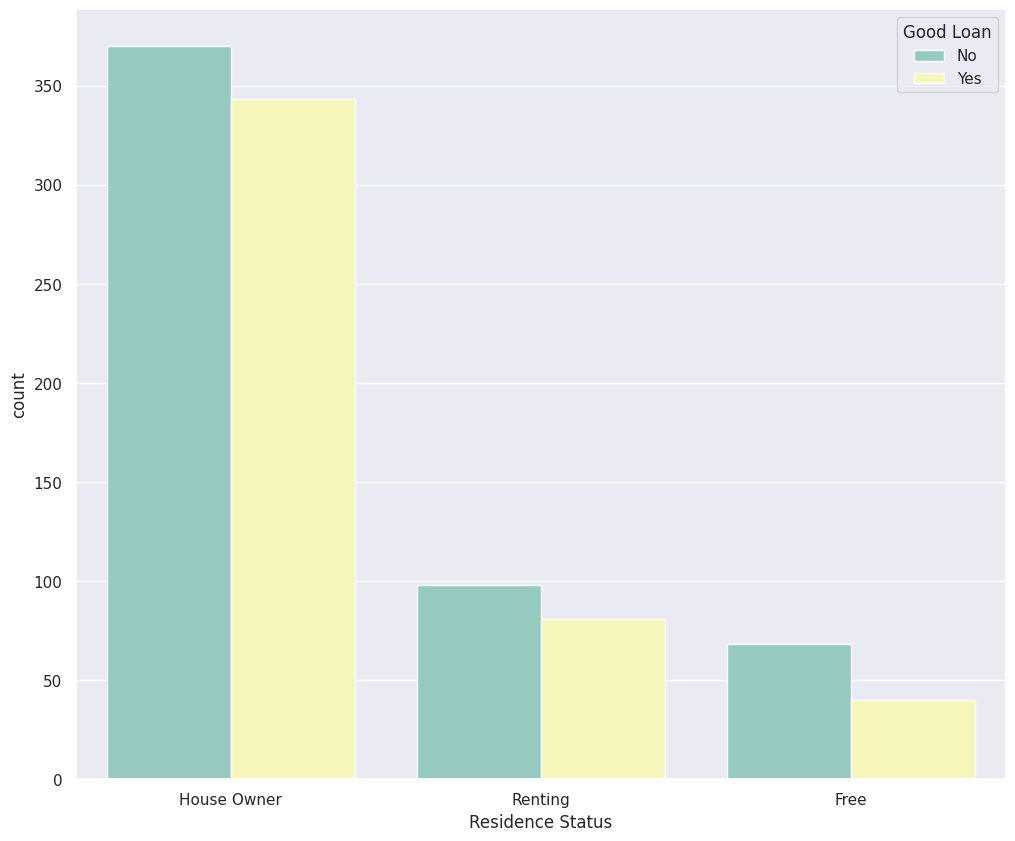

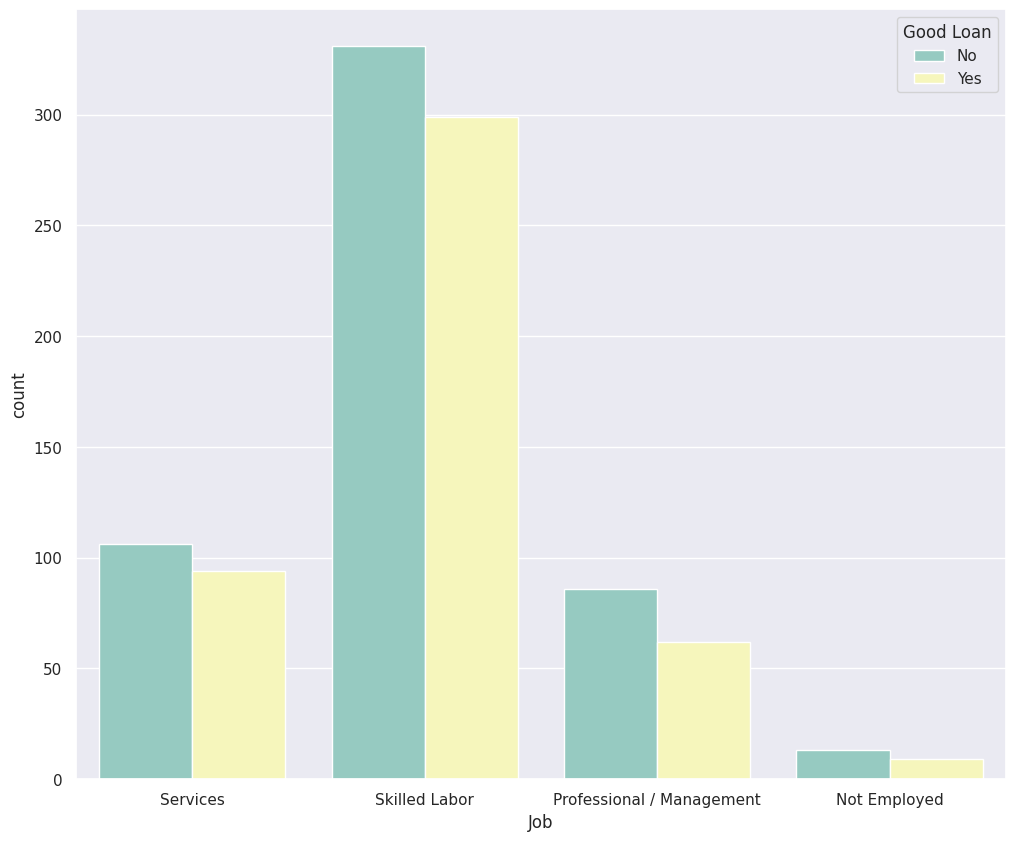

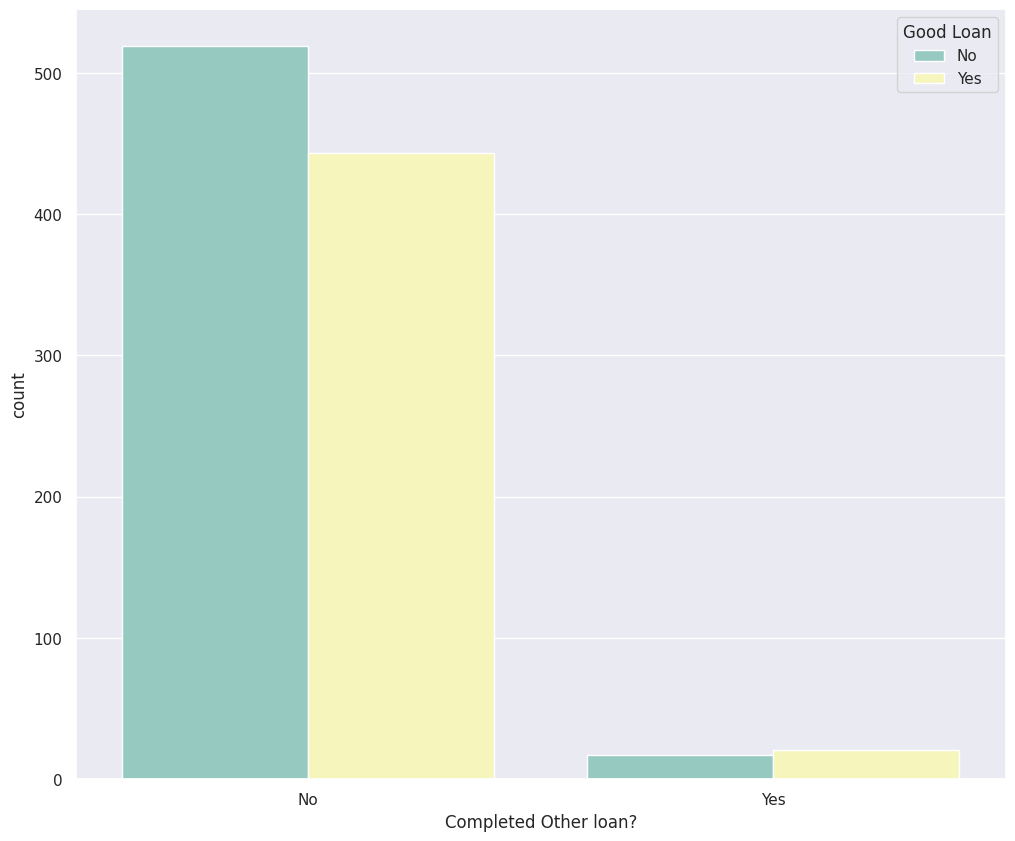

In [19]:
features = ['Type of Account', 'Account History', 'Reason for the Loan',
       'Account Savings', 'Employment History',
       'Individual Stauts', 'Other Loans', 'Security / Collateral',
       'Residence Status', 'Job', 'Completed Other loan?']

for f in features:
    sns.countplot(x = f, data = raw_data, palette = 'Set3', hue = 'Good Loan')
    plt.show()

In [20]:
# Making categorical variables into numeric representation

new_raw_data = pd.get_dummies(raw_data, columns = features)

print(raw_data.shape)
print(new_raw_data.shape)

# Creating a new 0-1 y variable
#new_raw_data['Loan Approved2'] = 0
new_raw_data['Good Loan'][new_raw_data['Good Loan'] == 'Yes'] = 1
new_raw_data['Good Loan'][new_raw_data['Good Loan'] == 'No'] = 0

# Visualizing the data
new_raw_data

(1000, 14)
(1000, 49)


,Loan Amount,Age,Good Loan,Type of Account_No Data,Type of Account_Type A,Type of Account_Type B,Type of Account_Type C,Account History_Average (known delays),Account History_Good,Account History_critical,...,Security / Collateral_Vehicle,Residence Status_Free,Residence Status_House Owner,Residence Status_Renting,Job_Not Employed,Job_Professional / Management,Job_Services,Job_Skilled Labor,Completed Other loan?_No,Completed Other loan?_Yes
0,2116.0,47.0,0,True,False,False,False,False,False,True,...,False,False,True,False,False,False,True,False,True,False
1,2438.0,52.0,0,True,False,False,False,False,False,True,...,False,False,True,False,False,False,False,True,True,False
2,2144.0,48.0,0,True,False,False,False,False,False,True,...,True,False,True,False,False,False,False,True,True,False
3,2073.0,25.0,0,True,False,False,False,False,False,True,...,True,False,True,False,False,False,False,True,False,True
4,1276.0,59.0,0,True,False,False,False,False,False,True,...,False,False,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,3602.0,47.0,0,False,False,False,True,True,False,False,...,False,False,True,False,False,False,True,False,True,False
1000,4473.0,35.0,0,False,False,False,True,True,False,False,...,False,False,True,False,False,False,False,True,True,False
1001,12759.0,38.0,1,False,False,False,True,True,False,False,...,True,False,True,False,False,True,False,False,True,False
1002,2551.0,47.0,0,False,False,False,True,True,False,False,...,True,False,True,False,False,False,True,False,True,False


Feature Selection

In [21]:
# Split the data into X & y

X = new_raw_data.drop('Good Loan', axis = 1).values
y = new_raw_data['Good Loan']

y = y.astype(int)

print(X.shape)
print(y.shape)

(1000, 48)
(1000,)


In [22]:
dt = DecisionTreeClassifier(random_state=15, criterion = 'entropy', max_depth = 10)
dt.fit(X,y)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=15)

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from typing import Union, Optional

def get_feature_importance(
    model: BaseEstimator,
    X: pd.DataFrame,
    target_col: str = "Good Loan",
    top_n: Optional[int] = None,
    plot: bool = True,
):
    """
    Return a sorted Series of feature importances for a fitted tree-based model.

    Parameters
    ----------
    model : sklearn BaseEstimator
        Must have the attribute `feature_importances_` (e.g., DecisionTree, RandomForest, XGBoost).
    X : pd.DataFrame
        Original data that includes the target column.
    target_col : str
        Name of the target column to drop before extracting features.
    top_n : int or None
        If given, keep only the top_n most important features.
    plot : bool
        Whether to render a horizontal bar plot.

    Returns
    -------
    pd.Series
        Index = feature names, values = importance (sorted descending).
    """

    if hasattr(model, "feature_names_in_"):
        feature_names = model.feature_names_in_
    else:
        feature_names = X.drop(columns=target_col).columns

    importances = pd.Series(model.feature_importances_, index=feature_names, name="importance")
    importances = importances.sort_values(ascending=False)

    if top_n is not None:
        importances = importances.iloc[:top_n]

    display(importances.to_frame())

    if plot:
        ax = importances.iloc[::-1].plot.barh()
        ax.set_title("Feature Importance")
        ax.set_xlabel("Importance")
        plt.tight_layout()
        plt.show()

    return importances


,importance
Account Savings_0-200,0.197515
Account History_Good,0.191316
Loan Amount,0.121221
Age,0.079630
Type of Account_No Data,0.054236
Type of Account_Type A,0.049733
Type of Account_Type C,0.026698
Job_Skilled Labor,0.020597
Other Loans_Yes,0.017520
Account Savings_No Data,0.016471


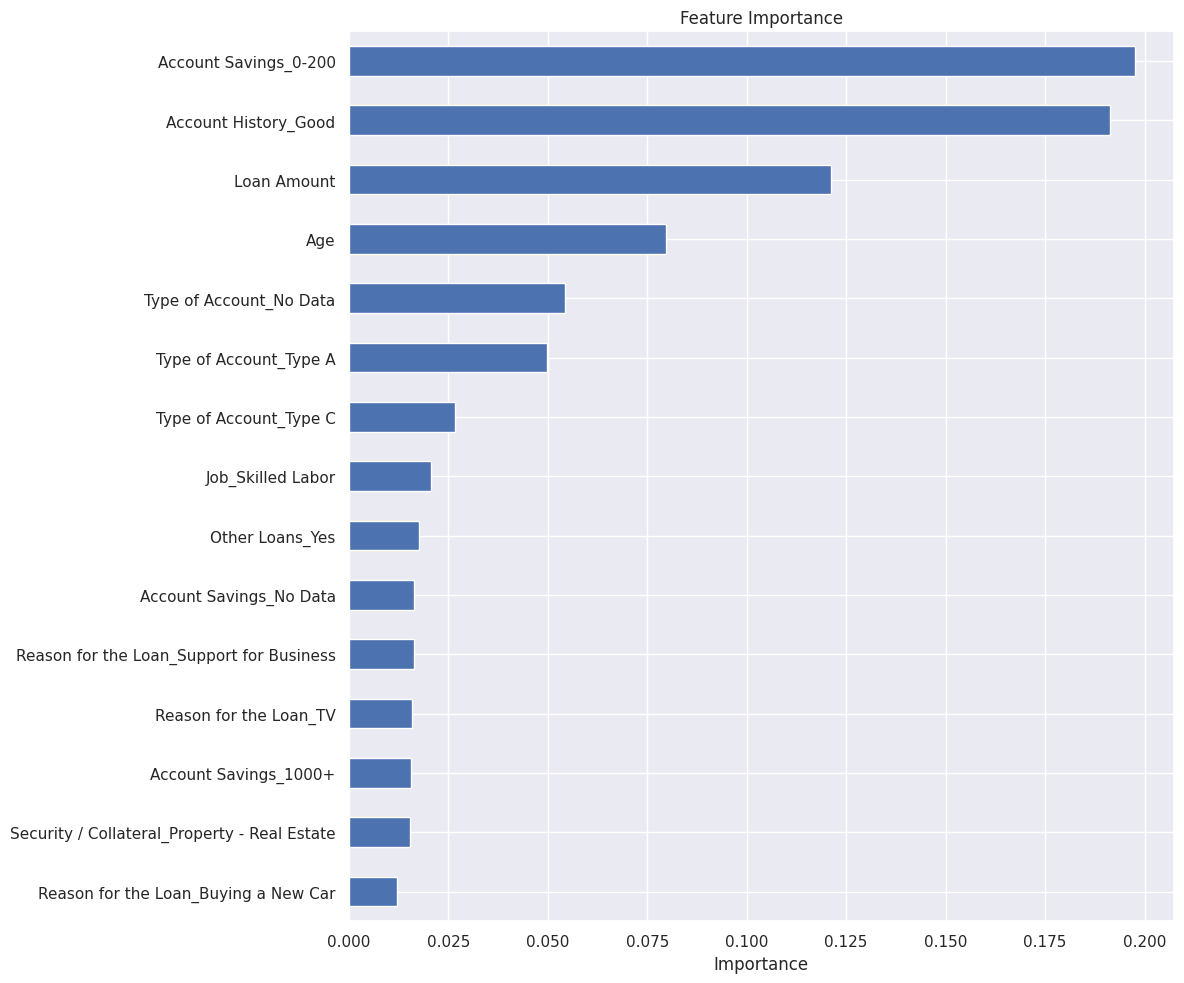

In [25]:
fi_series = get_feature_importance(
    model=dt,
    X=new_raw_data,
    target_col="Good Loan",
    top_n=15,
    plot=True
)


# fi_series.to_csv("feature_importance.csv")

Splitting the Raw data

In [28]:
import numpy as np

if hasattr(dt, "feature_names_in_"):
    feat_names = dt.feature_names_in_
else:
    feat_names = new_raw_data.drop(columns="Good Loan").columns

importances = dt.feature_importances_

sorted_idx = np.argsort(importances)[::-1]

top_n = 40
columns_to_keep = [feat_names[i] for i in sorted_idx[:top_n]]

print("columns_to_keep :", columns_to_keep)

columns_to_keep : ['Account Savings_0-200', 'Account History_Good', 'Loan Amount', 'Age', 'Type of Account_No Data', 'Type of Account_Type A', 'Type of Account_Type C', 'Job_Skilled Labor', 'Other Loans_Yes', 'Account Savings_No Data', 'Reason for the Loan_Support for Business', 'Reason for the Loan_TV', 'Account Savings_1000+', 'Security / Collateral_Property - Real Estate', 'Reason for the Loan_Buying a New Car', 'Job_Services', 'Residence Status_House Owner', 'Employment History_0-2 Years', 'Reason for the Loan_Home furniture', 'Account Savings_200-500', 'Security / Collateral_No Security', 'Individual Stauts_Married', 'Security / Collateral_Vehicle', 'Employment History_5-7 Years', 'Reason for the Loan_Renovation', 'Individual Stauts_Divorced', 'Reason for the Loan_Buying a Used Car', 'Employment History_Unemployed', 'Residence Status_Free', 'Account Savings_500-1000', 'Job_Professional / Management', 'Completed Other loan?_No', 'Completed Other loan?_Yes', 'Reason for the Loan_Lea

In [30]:
print(new_raw_data.shape)
print(new_raw_data[columns_to_keep].shape)

(1000, 49)
(1000, 40)


In [31]:
new_raw_data.head()

,Loan Amount,Age,Good Loan,Type of Account_No Data,Type of Account_Type A,Type of Account_Type B,Type of Account_Type C,Account History_Average (known delays),Account History_Good,Account History_critical,...,Security / Collateral_Vehicle,Residence Status_Free,Residence Status_House Owner,Residence Status_Renting,Job_Not Employed,Job_Professional / Management,Job_Services,Job_Skilled Labor,Completed Other loan?_No,Completed Other loan?_Yes
0,2116.0,47.0,0,True,False,False,False,False,False,True,...,False,False,True,False,False,False,True,False,True,False
1,2438.0,52.0,0,True,False,False,False,False,False,True,...,False,False,True,False,False,False,False,True,True,False
2,2144.0,48.0,0,True,False,False,False,False,False,True,...,True,False,True,False,False,False,False,True,True,False
3,2073.0,25.0,0,True,False,False,False,False,False,True,...,True,False,True,False,False,False,False,True,False,True
4,1276.0,59.0,0,True,False,False,False,False,False,True,...,False,False,False,True,False,False,True,False,True,False


In [32]:
X = new_raw_data[columns_to_keep].values
X

y = new_raw_data['Good Loan']
y = y.astype(int)
y

print(X.shape)
print(y.shape)

(1000, 40)
(1000,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state=15)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size = 0.9, test_size=0.1, random_state=15)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(720, 40)
(200, 40)
(80, 40)
(720,)
(200,)
(80,)


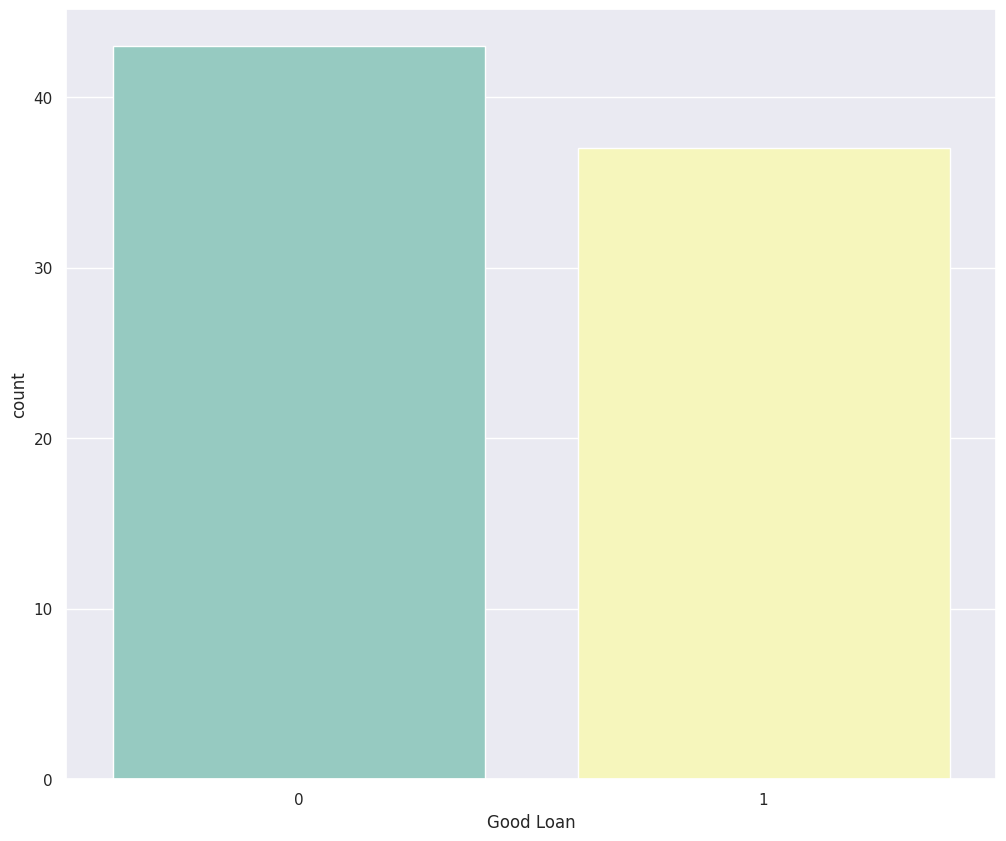

In [34]:
ax = sns.countplot(x = y_valid, palette = "Set3")

Logistic Regression

In [35]:
log_reg = LogisticRegression(random_state=10, solver = 'lbfgs')

log_reg.fit(X_train, y_train)

LogisticRegression(random_state=10)

In [36]:
log_reg.predict(X_train)
y_pred = log_reg.predict(X_train)

pred_proba = log_reg.predict_proba(X_train)

log_reg.coef_

array([[-1.434926, 1.797213, -0.000133, 0.008828, -1.441642, 0.902328,
        -0.257436, -0.047097, 0.276577, 0.493746, 0.170781, 0.076028,
        0.284252, 0.435359, -0.694199, -0.139949, 0.061756, -0.446187,
        0.280558, 0.167091, -0.425748, 0.028230, -0.097499, 0.528466,
        -0.166479, 0.008999, 0.439878, 0.051810, -0.013183, 0.381759,
        0.120355, -0.241995, 0.133916, -0.296198, -0.014182, 0.102342,
        -0.020191, 0.216097, -0.247650, -0.156651]])

In [37]:
print("The Training Accuracy is: ", log_reg.score(X_train, y_train))

print("The Testing Accuracy is: ", log_reg.score(X_test, y_test))

print(classification_report(y_train, y_pred))

The Training Accuracy is:  0.7861111111111111
The Testing Accuracy is:  0.765
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       387
           1       0.77      0.76      0.77       333

    accuracy                           0.79       720
   macro avg       0.79      0.78      0.78       720
weighted avg       0.79      0.79      0.79       720



In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Sequence, Union, Optional

def plot_confusion_matrix(
        cm: Union[np.ndarray, 'pd.DataFrame'],
        classes: Optional[Sequence[str]] = None,
        normalize: bool = False,
        title: str = "Confusion matrix",
        figsize: tuple = (6, 5),
        cmap: str = "YlGnBu",
        savepath: Optional[str] = None,
        ax: Optional[plt.Axes] = None,
        annot_fmt: Optional[str] = None,
    ):
    """
    Better confusion-matrix plotter.

    Parameters
    ----------
    cm : array-like
        Confusion matrix (counts). Shape = (n_classes, n_classes).
    classes : list[str], optional
        Class names for tick labels.
    normalize : bool, default False
        If True, each row is converted to percentages.
    title : str
        Plot title.
    figsize : tuple
        New figure size in inches (ignored if `ax` is given).
    cmap : str or Colormap
        Colormap passed to seaborn.heatmap.
    savepath : str, optional
        If given, saves the figure to this path (png, pdf, …).
    ax : matplotlib Axes, optional
        Axes to draw on.  If None, a new figure/axes is created.
    annot_fmt : str, optional
        Format string for annotations.  If None, automatically selected
    """
    # ──────────────────────────────────────────────────────
    cm = np.asarray(cm)

    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1e-6)
        annot_fmt = annot_fmt or ".2f"
    else:
        annot_fmt = annot_fmt or "d"

    vmax = cm.max()

    # ──────────────────────────────────────────────────────
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    sns.heatmap(
        cm,
        ax=ax,
        cmap=cmap,
        vmin=0,
        vmax=vmax,
        annot=True,
        fmt=annot_fmt,
        xticklabels=classes if classes is not None else "auto",
        yticklabels=classes if classes is not None else "auto",
        cbar_kws={"label": "Proportion" if normalize else "Count"},
        annot_kws={"size": 11}
    )

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")

    return ax


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

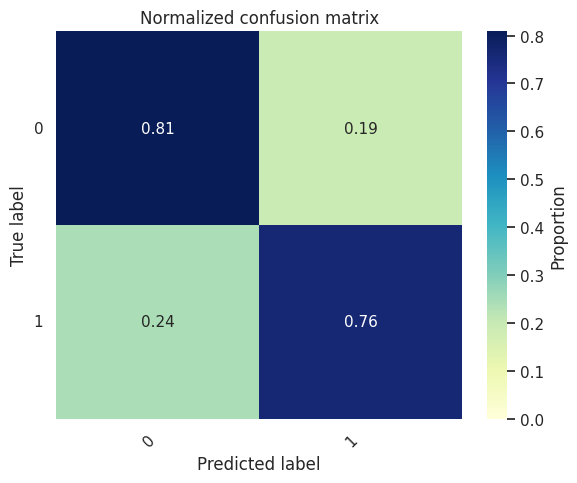

In [40]:
from sklearn.metrics import confusion_matrix

y_pred = log_reg.predict(X_train)
cm      = confusion_matrix(y_train, y_pred)

plot_confusion_matrix(
    cm,
    classes=log_reg.classes_,
    normalize=True,
    title="Normalized confusion matrix"
)

In [41]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)

FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print("The True Positive Rate is:", TPR)

# Precision or positive predictive value
PPV = TP / (TP + FP)
print("The Precision is:", PPV)

# False positive rate or False alarm rate
FPR = FP / (FP + TN)
print("The False positive rate is:", FPR)


# False negative rate or Miss Rate
FNR = FN / (FN + TP)
print("The False Negative Rate is: ", FNR)



##Total averages :
print("")
print("The average TPR is:", TPR.sum()/2)
print("The average Precision is:", PPV.sum()/2)
print("The average False positive rate is:", FPR.sum()/2)
print("The average False Negative Rate is:", FNR.sum()/2)

The True Positive Rate is: [0.808786 0.759760]
The Precision is: [0.796438 0.773700]
The False positive rate is: [0.240240 0.191214]
The False Negative Rate is:  [0.191214 0.240240]

The average TPR is: 0.784272644737761
The average Precision is: 0.7850689824217382
The average False positive rate is: 0.21572735526223896
The average False Negative Rate is: 0.21572735526223896


Hyper parameter tuning

In [42]:
np.geomspace(1e-5, 1e5, num=20)

array([0.000010, 0.000034, 0.000113, 0.000379, 0.001274, 0.004281,
       0.014384, 0.048329, 0.162378, 0.545559, 1.832981, 6.158482,
       20.691381, 69.519280, 233.572147, 784.759970, 2636.650899,
       8858.667904, 29763.514416, 100000.000000])

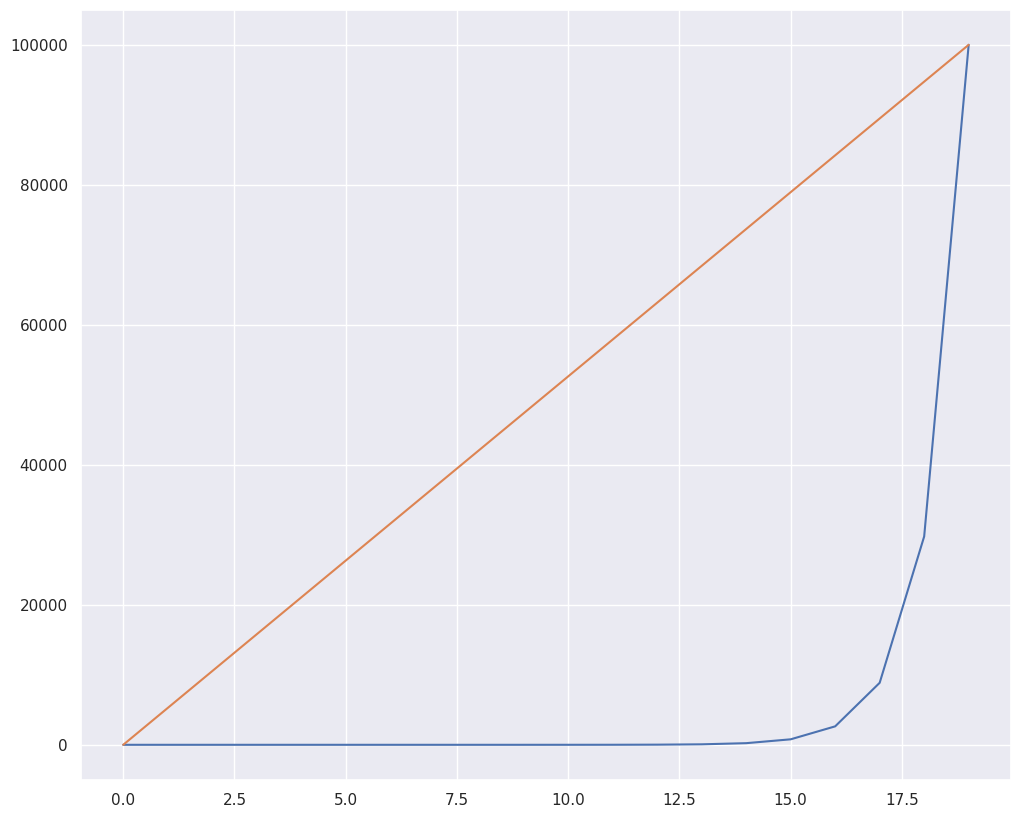

In [43]:
np.geomspace(1e-5, 1e5, num=20)


plt.plot(np.geomspace(1e-5, 1e5, num=20))
plt.plot(np.linspace(1e-5, 1e5, num=20))

In [44]:
C_List = np.geomspace(1e-5, 1e5, num=20)
CA = []
Logarithmic_Loss = []

for c in C_List:
    log_reg2 = LogisticRegression(random_state=10, solver = 'lbfgs', C=c)
    log_reg2.fit(X_train, y_train)
    score = log_reg2.score(X_test, y_test)
    CA.append(score)
    print("The CA of C parameter {} is {}:".format(c, score))
    pred_proba_t = log_reg2.predict_proba(X_test)
    log_loss2 = log_loss(y_test, pred_proba_t)
    Logarithmic_Loss.append(log_loss2)
    print("The Logg Loss of C parameter {} is {}:".format(c, log_loss2))
    print("")

The CA of C parameter 1e-05 is 0.535:
The Logg Loss of C parameter 1e-05 is 0.6962407758617359:

The CA of C parameter 3.359818286283781e-05 is 0.495:
The Logg Loss of C parameter 3.359818286283781e-05 is 0.6957690249510342:

The CA of C parameter 0.00011288378916846884 is 0.515:
The Logg Loss of C parameter 0.00011288378916846884 is 0.6943867484781228:

The CA of C parameter 0.000379269019073225 is 0.555:
The Logg Loss of C parameter 0.000379269019073225 is 0.6894471089463261:

The CA of C parameter 0.0012742749857031334 is 0.6:
The Logg Loss of C parameter 0.0012742749857031334 is 0.6737780664600551:

The CA of C parameter 0.004281332398719391 is 0.655:
The Logg Loss of C parameter 0.004281332398719391 is 0.6356103297405995:

The CA of C parameter 0.01438449888287663 is 0.72:
The Logg Loss of C parameter 0.01438449888287663 is 0.5731793283266704:

The CA of C parameter 0.04832930238571752 is 0.71:
The Logg Loss of C parameter 0.04832930238571752 is 0.5223359660364234:

The CA of C pa

In [ ]:
# For each regularization strength C in C_List, the loop trains a LogisticRegression model.
# It evaluates the model on the test set, appending the resulting accuracy score to CA and printing it.
# Using the predicted probabilities, it also computes the logarithmic loss (log loss), stores it in Logarithmic_Loss, and prints the value.
# This provides a per-C comparison of accuracy versus log loss, guiding hyper-parameter selection.

In [45]:
# reshaping
CA2 = np.array(CA).reshape(20,)
Logarithmic_Loss2 = np.array(Logarithmic_Loss).reshape(20,)

# zip
outcomes = zip(C_List, CA2, Logarithmic_Loss2)

#df
df_outcomes = pd.DataFrame(outcomes, columns = ["C_List", 'CA2','Logarithmic_Loss2'])

#print
df_outcomes

# Ordering the data (sort_values)
df_outcomes.sort_values("Logarithmic_Loss2", ascending = True).reset_index()

,index,C_List,CA2,Logarithmic_Loss2
0,15,784.759970,0.775,0.487452
1,16,2636.650899,0.775,0.487491
2,12,20.691381,0.770,0.490300
3,19,100000.000000,0.760,0.491929
4,9,0.545559,0.765,0.492611
5,13,69.519280,0.770,0.493162
6,18,29763.514416,0.770,0.493201
7,17,8858.667904,0.770,0.493223
8,10,1.832981,0.750,0.493656
9,14,233.572147,0.755,0.494142


In [46]:
# Final Model

log_reg3 = LogisticRegression(random_state=10, solver = 'lbfgs', C=784.759970)
log_reg3.fit(X_train, y_train)
score = log_reg3.score(X_valid, y_valid)

pred_proba_t = log_reg3.predict_proba(X_valid)
log_loss2 = log_loss(y_valid, pred_proba_t)

print("Testing Acc:", score)
print("Log Loss:", log_loss2)

Testing Acc: 0.7625
Log Loss: 0.43314320690352864
